In [1]:
import torch, torchaudio
from torch import nn
from torch.nn import functional as F

In [2]:
import pytorch_lightning as pl
from pytorch_lightning.metrics import functional

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
torch.cuda.is_available()

True

# Step 1: Some experiments in audio loading and transformation

In [5]:
datapath = Path('data/ESC-50')

In [6]:
datapath.exists()

True

In [7]:
csv = pd.read_csv(datapath/Path('meta/esc50.csv'))

In [8]:
csv.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [9]:
x, sr = torchaudio.load(datapath/'audio'/csv.iloc[0,0], normalize=True)
x.shape

torch.Size([1, 220500])

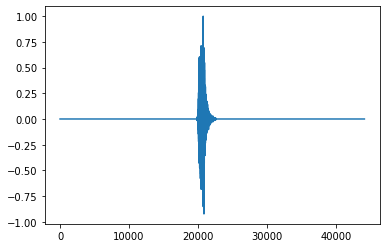

In [10]:
_ = plt.plot(x[0, ::5])

In [11]:
torchaudio.transforms.Resample(orig_freq=sr, new_freq=8000)(x).shape

torch.Size([1, 40000])

In [12]:
h = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(x)

/home/casey/anaconda3/envs/reprodl/lib/python3.9/site-packages/torchaudio/functional/functional.py:432: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


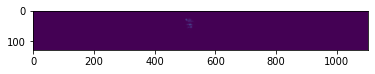

In [13]:
plt.imshow(h[0])

In [14]:
h.shape

torch.Size([1, 128, 1103])

In [15]:
h = torchaudio.transforms.AmplitudeToDB()(h)

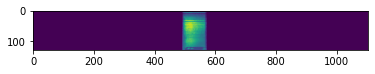

In [16]:
plt.imshow(h[0])

# Step 2: Putting together data loading and preprocessing

In [17]:
class ESC50Dataset(torch.utils.data.Dataset):
    def __init__(self, path: Path = Path('data/ESC-50'), sample_rate:int = 8000, folds=[1]) -> None:
        super().__init__()
        # Load csv
        self.path = path
        self.csv = pd.read_csv(path/Path('meta/esc50.csv'))
        self.csv = self.csv[self.csv['fold'].isin(folds)]
        
        # Transform
        self.resample = torchaudio.transforms.Resample(orig_freq=44100, new_freq=sample_rate)
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)
        self.db = torchaudio.transforms.AmplitudeToDB(top_db=80)
        
    def __getitem__(self, index):
        """Return (xb, yb) pair, after applying all transformations on the audio file

        Args:
            index (int): index of pair
        """
        
        row = self.csv.iloc[index]
        wav, _ = torchaudio.load(self.path/'audio'/row['filename'])
        label = row['target']
        xb = self.db(self.melspec(self.resample(wav)))
        return xb, label
    
    def __len__(self):
        """Get total number of samples in dataset

        Returns:
            int: Number of samples
        """
        return len(self.csv)        

In [18]:
train_data = ESC50Dataset()

In [19]:
for xb, yb in train_data:
    break

In [20]:
xb.shape

torch.Size([1, 128, 201])

In [21]:
yb

0

# Step 3: Build a classification model

In [22]:
train_data = ESC50Dataset(folds=[1,2,3])
val_data = ESC50Dataset(folds=[4])
test_data = ESC50Dataset(folds=[5])

In [23]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8)

In [ ]:
class AudioNet(pl.LightningModule):
    def __init__(self, n_classes = 50, base_filters= 32 , *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=base_filters, kernel_size=11, padding=5)
        self.bn1 = nn.BatchNorm2d(num_features=base_filters)
        self.conv2 = nn.Conv2d(in_channels=base_filters, out_channels=base_filters, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=base_filters)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=base_filters, out_channels=base_filters * 2, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=base_filters * 2)
        self.conv4 = nn.Conv2d(in_channels=base_filters*2, out_channels=base_filters*4, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=base_filters*4)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=base_filters*4, out_features=n_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool1(x)
        
        x = self.conv3(x)
        